In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js
from scipy.stats import linregress
from operator import itemgetter

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.added_points.append(PointsCollection())
         
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.added_lines.append(LinesCollection())

    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add((self.new_line_point, new_point))
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines = [], **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        return [b_prev, b_next, b_add_point, b_add_line]
    
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes
        
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(self.callback)
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()

In [3]:
class KDTreeNode:
    def __init__(self, vector, axis, leftTree, rightTree):
        self.vector = vector
        self.axis = axis
        self.leftTree = leftTree
        self.rightTree = rightTree


class KDTree:
    def __init__(self, dimensions, root):
        self.dimensions = dimensions
        self.root = root

    def construct(self, pointsList, axis):
        if len(pointsList) == 0:
            return None
        pointsList = sorted(pointsList, key=itemgetter(axis))
        median = int(len(pointsList)/2)
        node = KDTreeNode(pointsList[median], axis, None, None)
        node.leftTree = self.construct(pointsList[:median], (axis + 1) % self.dimensions)
        node.rightTree = self.construct(pointsList[median + 1:], (axis + 1) % self.dimensions)
        return node
    
    def constructVisualization(self,pointsCopy, previousPoint, pointsList, axis, sceneList,linesList, minX, minY, maxX, maxY):
        if len(pointsList) == 0:
            return None
        pointsList = sorted(pointsList, key=itemgetter(axis))
        median = int(len(pointsList)/2)
        line = None
        if axis == 0:
            y1 = None
            y2 = None
            if pointsList[median][1] >= previousPoint[1]:
                y1 = previousPoint[1]
                y2 = maxY
            else:
                y1=minY
                y2 = previousPoint[1]
            line = ((pointsList[median][0],y1),(pointsList[median][0],y2))
        else:
            x1 = None
            x2 = None
            if pointsList[median][0] > previousPoint[0]:
                x1 = previousPoint[0]
                x2 = maxX
            else:
                x1 = minX
                x2 = previousPoint[0]
            line = ((x1,pointsList[median][1]),(x2,pointsList[median][1]))
        points = [PointsCollection(pointsCopy, color='blue'), PointsCollection([pointsList[median]], color='green')]
        lines = [LinesCollection(list(linesList), color='red'), LinesCollection([line], color='red')]   
        scene = Scene(points, lines)
        sceneList.append(scene)
        points = [PointsCollection(pointsCopy, color='blue'), PointsCollection([pointsList[median]], color='blue')]
        sceneList.append(Scene(points, lines))
        linesList.append(line)
        node = KDTreeNode(pointsList[median], axis, None, None)
        if axis == 0:
            node.leftTree = self.constructVisualization(pointsCopy,pointsList[median],pointsList[:median], (axis + 1) % self.dimensions, sceneList, linesList, minX, minY, pointsList[median][0], maxY)
            node.rightTree = self.constructVisualization(pointsCopy,pointsList[median],pointsList[median + 1:], (axis + 1) % self.dimensions, sceneList, linesList, pointsList[median][0], minY, maxX, maxY)
        else:
            node.leftTree = self.constructVisualization(pointsCopy,pointsList[median],pointsList[:median], (axis + 1) % self.dimensions, sceneList, linesList, minX, minY, maxX, pointsList[median][1])
            node.rightTree = self.constructVisualization(pointsCopy,pointsList[median],pointsList[median + 1:], (axis + 1) % self.dimensions, sceneList, linesList, minX, pointsList[median][1], maxX, maxY)
        return node

    def printTree(self, root):
        if root is None:
            print("None")
            return
        self.printTree(root.leftTree)
        print(root.vector)
        self.printTree(root.rightTree)

    def printMe(self):
        self.printTree(self.root)

    def search(self, root, point, axis):
        if root is None:
            return False
        if root.vector == point:
            return True
        elif point[axis] > root.vector[axis]:
            return self.search(root.rightTree, point, (axis + 1) % self.dimensions)
        else:
            return self.search(root.leftTree, point, (axis + 1) % self.dimensions)

    def searchPoint(self, point):
        return self.search(self.root, point, 0)

    def add(self, point, root, previous, axis):
        if root is None:
            if previous.vector[(axis - 1) % self.dimensions] > point[(axis - 1) % self.dimensions]:
                previous.leftTree = KDTreeNode(point, axis, None, None)
            else:
                previous.rightTree = KDTreeNode(point, (axis + 1) % self.dimensions, None, None)
        elif root.vector[axis] > point[axis]:
            self.add(point, root.leftTree, root, (axis + 1) % self.dimensions)
        else:
            self.add(point, root.rightTree, root, (axis + 1) % self.dimensions)

    def addPoint(self, point):
        if self.root is None:
            self.root = KDTreeNode(point, 0, None, None)
        self.add(point, self.root, None, 0)

    def square(self, root, x1, x2, y1, y2, resultList):
        if root is None:
            return
        if x1 <= root.vector[0] <= x2 and y1 <= root.vector[1] <= y2:
            resultList.append(root)
        if root.axis == 0:
            if root.vector[0] >= x1:
                self.square(root.leftTree, x1, x2, y1, y2, resultList)
            if root.vector[0] <= x2:
                self.square(root.rightTree, x1, x2, y1, y2, resultList)
        else:
            if root.vector[1] >= y1:
                self.square(root.leftTree, x1, x2, y1, y2, resultList)
            if root.vector[1] <= y2:
                self.square(root.rightTree, x1, x2, y1, y2, resultList)
                
    def squareVisualization(self, root, x1, x2, y1, y2, resultList, sceneList, pointsCopy, linesCopy):
        if root is None:
            return
        points = pointsCopy+[PointsCollection([root.vector], color = 'yellow')]
        lines = linesCopy+[LinesCollection([((x1,y1),(x2,y1)),((x2,y1),(x2,y2)),((x2,y2),(x1,y2)),((x1,y2),(x1,y1))], color = 'yellow')]
        sceneList.append(Scene(points, lines))
        if x1 <= root.vector[0] <= x2 and y1 <= root.vector[1] <= y2:
            resultList.append(root)
            points=pointsCopy+[PointsCollection([root.vector], color = 'brown')]
            sceneList.append(Scene(points, lines))
        if root.axis == 0:
            if root.vector[0] >= x1:
                self.squareVisualization(root.leftTree, x1, x2, y1, y2, resultList, sceneList, pointsCopy, linesCopy)
            if root.vector[0] <= x2:
                self.squareVisualization(root.rightTree, x1, x2, y1, y2, resultList, sceneList, pointsCopy, linesCopy)
        else:
            if root.vector[1] >= y1:
                self.squareVisualization(root.leftTree, x1, x2, y1, y2, resultList, sceneList, pointsCopy, linesCopy)
            if root.vector[1] <= y2:
                self.squareVisualization(root.rightTree, x1, x2, y1, y2, resultList, sceneList, pointsCopy, linesCopy)

    def findPointsInSquare(self, x1, x2, y1, y2):
        result = list()
        self.square(self.root, x1, x2, y1, y2, result)
        return result
    
    def findPointsInSquareVisualization(self, x1, x2, y1, y2, sceneList, pointsCopy, linesCopy):
        result = list()
        self.squareVisualization(self.root, x1, x2, y1, y2, result, sceneList, pointsCopy, linesCopy)
        return result


def constructKDTree(pointsList):
    dimensions = len(pointsList[0])
    result = KDTree(dimensions, None)
    result.root = result.construct(pointsList, 0)
    return result

def constructKDTreeVisualization(pointsList, sceneList):
    dimensions = len(pointsList[0])
    maxX = pointsList[0][0]
    maxY = pointsList[0][1]
    minX = pointsList[0][0]
    minY = pointsList[0][1]
    for p in pointsList:
        maxX = max(maxX, p[0])
        minX = min(minX, p[0])
        maxY = max(maxY, p[1])
        minY = min(minY, p[1])
    linesList = []
    result = KDTree(dimensions, None)
    result.root = result.constructVisualization(pointsList,(minX, minY),pointsList, 0, sceneList, linesList, minX, minY, maxX, maxY)
    return result

                       

USER INPUT

<IPython.core.display.Javascript object>


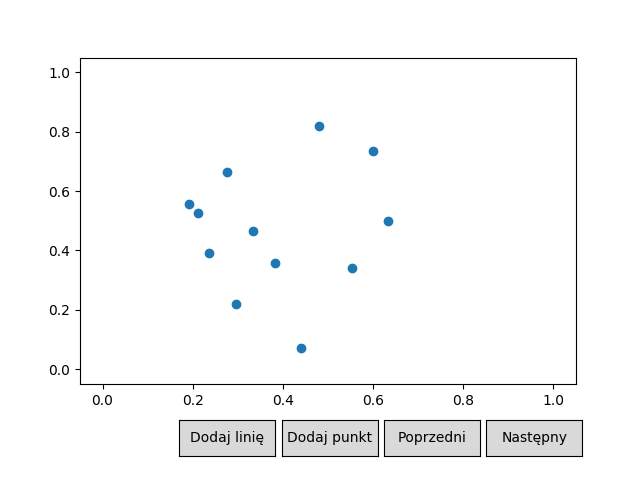

In [4]:
%matplotlib notebook
plot=Plot()
plot.draw()

12


<IPython.core.display.Javascript object>


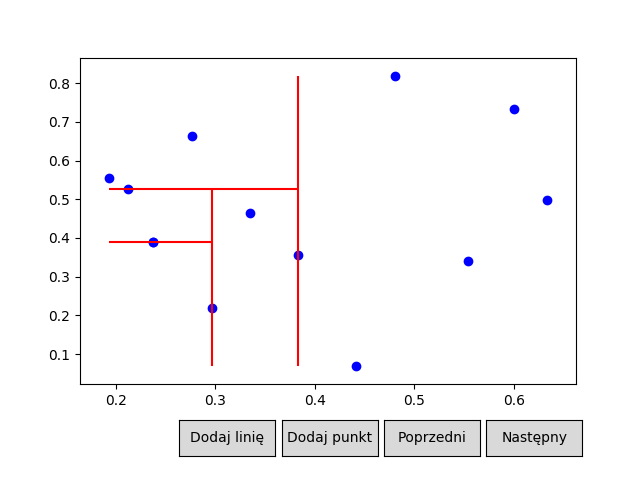

In [5]:
%matplotlib notebook
sceneList=[]
print(len(plot.get_added_points()[0].points))
tree = constructKDTreeVisualization(plot.get_added_points()[0].points, sceneList)
treePlot = Plot(sceneList)
treePlot.draw()

<IPython.core.display.Javascript object>


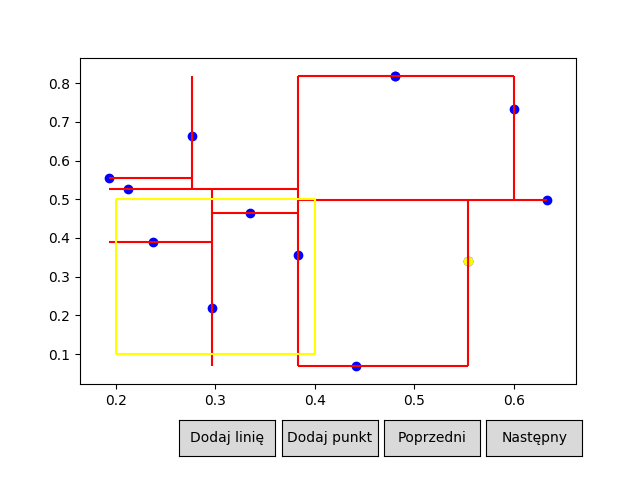

In [6]:
%matplotlib notebook
scene = sceneList[-1]
scenes = [scene]
tree.findPointsInSquareVisualization(0.2, 0.4, 0.1, 0.5, scenes, scene.points, scene.lines)
plotSquare = Plot(scenes)
plotSquare.draw()